# Phase 3B: Sharpe Ratio Optimization

**Goal**: Improve Sharpe ratio from -0.10 to >0.5 while maintaining 58%+ win rate

This notebook tests the new optimization modules:
- Signal filtering (confidence threshold, regime filtering)
- Position sizing (Kelly criterion, volatility scaling)
- Enhanced risk management (trailing stops, take profits)

In [46]:
# Setup
import sys
import os
from pathlib import Path

# Add project root to path
project_root = Path.cwd().parent
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

import pandas as pd
import numpy as np
import yaml
import warnings
warnings.filterwarnings('ignore')

print(f"Project root: {project_root}")

Project root: C:\Users\Abdulfatai Sanusi\Desktop\FOREX MODEL\forex_signal_model


In [47]:
# Load configuration and data
with open(project_root / 'config' / 'config.yaml', 'r') as f:
    config = yaml.safe_load(f)

# Load features
features_path = project_root / 'data' / 'processed' / 'features.parquet'
df = pd.read_parquet(features_path)
print(f"Loaded {len(df)} samples with {len(df.columns)} features")

Loaded 1509 samples with 213 features


## 1. Import New Optimization Modules

In [48]:
# Import new modules
from src.signal_filter import SignalFilter
from src.position_sizer import PositionSizer
from src.risk_management import RiskManager
from src.regime_detector import MarketRegimeDetector

print("✅ All optimization modules loaded")

✅ All optimization modules loaded


In [49]:
# Initialize signal filter with updated config
import yaml
from pathlib import Path

# Load updated config
config_path = Path('../config/config.yaml')
with open(config_path, 'r') as f:
    config = yaml.safe_load(f)

# Extract filter config from YAML
filter_config = config.get('signal_filter', {
    'confidence_threshold': 0.50,
    'allowed_regimes': ['strong_trend_up', 'strong_trend_down', 'weak_trend', 'low_volatility', 'ranging'],
    'min_trade_gap': 1,
    'min_risk_reward': 1.5
})

# Create filter with config
signal_filter = SignalFilter({'signal_filter': filter_config})
print(f"✅ Signal Filter initialized:")
print(f"   Confidence threshold: {signal_filter.confidence_threshold}")
print(f"   Allowed regimes: {signal_filter.allowed_regimes}")
print(f"   Min trade gap: {signal_filter.min_trade_gap} days")

✅ Signal Filter initialized:
   Confidence threshold: 0.5
   Allowed regimes: ['strong_trend_up', 'strong_trend_down', 'weak_trend', 'low_volatility', 'ranging', 'normal', 'trending']
   Min trade gap: 1 days


## 2. Load Trained Models

In [50]:
import pickle

# Load walk-forward model
wf_model_path = project_root / 'results' / 'walk_forward' / 'best_wf_model.pkl'

if wf_model_path.exists():
    with open(wf_model_path, 'rb') as f:
        wf_model = pickle.load(f)
    print(f"✅ Loaded walk-forward model")
    
    # Extract model if wrapped in dict
    if isinstance(wf_model, dict) and 'model' in wf_model:
        model = wf_model['model']
        print(f"   Model type: {type(model).__name__}")
    else:
        model = wf_model
        print(f"   Model type: {type(model).__name__}")
else:
    print("❌ No walk-forward model found")

✅ Loaded walk-forward model
   Model type: XGBClassifier


## 3. Prepare Test Data

In [51]:
# Get feature columns
exclude_patterns = ['target', 'date', 'ticker', 'regime', 'signal', 'confidence']
feature_cols = [c for c in df.columns if not any(x in c.lower() for x in exclude_patterns)]

# Find target column
target_cols = [c for c in df.columns if 'target' in c.lower() and 'direction' in c.lower()]
if not target_cols:
    target_cols = [c for c in df.columns if 'target' in c.lower()]
target_col = target_cols[0] if target_cols else None

print(f"Features: {len(feature_cols)}")
print(f"Target: {target_col}")

# Use last 20% as test set
test_size = int(len(df) * 0.2)
test_df = df.iloc[-test_size:].copy()

print(f"Test set: {len(test_df)} samples")
print(f"Test period: {test_df.index[0]} to {test_df.index[-1]}")

Features: 203
Target: GBPUSD_Target_Direction
Test set: 301 samples
Test period: 2024-10-22 00:00:00 to 2026-01-02 00:00:00


## 4. Generate Predictions with Confidence

In [52]:
# Get model feature names and align test data
from src.feature_engineering import align_features_for_model, add_calendar_features

# Get model features
if isinstance(wf_model, dict) and 'feature_names' in wf_model:
    model_features = wf_model['feature_names']
else:
    try:
        model_features = model.get_booster().feature_names
    except:
        model_features = [c for c in test_df.columns if c not in ['Date', target_col, 'ticker', 'symbol']]

print(f"Model expects {len(model_features)} features")

# Prepare test data
X_test = test_df[[c for c in test_df.columns if c not in ['Date', target_col, 'ticker', 'symbol'] and 'Target' not in c]].copy()
y_test = test_df[target_col] if target_col else None

# Add calendar features if missing
if 'day_of_week' not in X_test.columns and hasattr(X_test.index, 'dayofweek'):
    X_test = add_calendar_features(X_test)
    print("Added calendar features")

# Align features to match model expectations
X_test_aligned = align_features_for_model(X_test, model_features)

# Generate predictions and probabilities
predictions = model.predict(X_test_aligned)
probabilities = model.predict_proba(X_test_aligned)[:, 1]

# Calculate confidence (distance from 0.5 * 2 * 100)
confidences = np.abs(probabilities - 0.5) * 2 * 100
test_df['raw_signal'] = predictions
test_df['probability'] = probabilities
test_df['confidence'] = confidences

print(f"\n✅ Predictions generated: {len(predictions)} samples")
print(f"   Positive signals: {(predictions == 1).sum()}")
print(f"   High confidence (>60%): {(confidences > 60).sum()}")

Model expects 221 features
Added calendar features
ℹ️ Removing 1 extra features not in model

✅ Predictions generated: 301 samples
   Positive signals: 206
   High confidence (>60%): 39


## 5. Apply Signal Filtering

In [53]:
# Detect regimes
regime_detector = MarketRegimeDetector(config)

# Get the main ticker - look for GBPUSD or first available
main_ticker = None
for ticker_prefix in ['GBPUSD', 'EURUSD', 'GC']:
    close_cols = [c for c in test_df.columns if ticker_prefix in c and 'Close' in c]
    if close_cols:
        main_ticker = ticker_prefix
        break

if main_ticker:
    print(f"Using ticker: {main_ticker}")
    # Use get_regime_history which handles the DataFrame properly
    try:
        regime_series = regime_detector.get_regime_history(test_df, main_ticker)
        test_df['regime'] = regime_series
    except Exception as e:
        print(f"Regime detection error: {e}")
        # Fallback to simple volatility-based regime
        atr_cols = [c for c in test_df.columns if 'ATR' in c]
        if atr_cols:
            atr_percentile = test_df[atr_cols[0]].rank(pct=True)
            test_df['regime'] = np.where(atr_percentile > 0.8, 'high_volatility',
                                  np.where(atr_percentile < 0.2, 'low_volatility', 'normal'))
        else:
            test_df['regime'] = 'normal'
else:
    test_df['regime'] = 'normal'

print(f"\n📊 Regime Distribution:")
print(test_df['regime'].value_counts())

Using ticker: GBPUSD

📊 Regime Distribution:
regime
weak_trend         235
low_volatility      46
high_volatility     20
Name: count, dtype: int64


In [54]:
# Apply signal filtering
filtered_signals, adjusted_conf, filter_reasons = signal_filter.filter_signals_batch(
    signals=pd.Series(predictions, index=test_df.index),
    confidences=pd.Series(confidences, index=test_df.index),
    regimes=test_df['regime'],
    dates=test_df.index
)

test_df['filtered_signal'] = filtered_signals
test_df['filter_reason'] = filter_reasons

print(f"\n📊 Signal Filtering Results:")
print(f"   Original signals: {(predictions != -1).sum()}")
print(f"   After filtering: {(filtered_signals != -1).sum()}")
print(f"   Filtered out: {(filtered_signals == -1).sum()}")
print(f"   Filter rate: {(filtered_signals == -1).sum() / len(filtered_signals) * 100:.1f}%")

print(f"\n   Filter breakdown:")
print(filter_reasons.value_counts())


📊 Signal Filtering Results:
   Original signals: 301
   After filtering: 60
   Filtered out: 241
   Filter rate: 80.1%

   Filter breakdown:
passed                                60
unfavorable_regime_high_volatility    11
low_confidence_15.2                    4
low_confidence_1.6                     3
low_confidence_50.0                    3
                                      ..
low_confidence_8.6                     1
low_confidence_15.1                    1
low_confidence_8.2                     1
low_confidence_18.0                    1
low_confidence_33.2                    1
Name: count, Length: 182, dtype: int64


## 6. Backtest with Optimizations

In [55]:
# Run backtest with volatility-scaled position sizing
def backtest_with_volatility_sizing(
    df,
    signals,
    close_col,
    atr_col,
    initial_capital=100000,
    transaction_cost=0.0003
):
    """Backtest with volatility-scaled position sizing for better Sharpe."""
    capital = initial_capital
    peak_capital = initial_capital
    position = 0
    entry_price = 0
    stop_loss = 0
    take_profit = 0
    
    trades = []
    equity_curve = [initial_capital]
    
    # Get ATR for volatility scaling
    atr_series = df[atr_col] if atr_col in df.columns else None
    avg_atr = atr_series.mean() if atr_series is not None else None
    
    close = df[close_col]
    
    for i in range(1, len(df)):
        current_price = close.iloc[i]
        signal = signals.iloc[i] if i < len(signals) else 0
        current_atr = atr_series.iloc[i] if atr_series is not None else 0
        
        # Check exits first
        if position != 0:
            # Check stop loss / take profit
            if position == 1:  # Long
                if current_price <= stop_loss or current_price >= take_profit:
                    exit_pnl = (current_price - entry_price) * abs(position_size)
                    capital += exit_pnl - (abs(position_size) * current_price * transaction_cost)
                    trades.append({
                        'entry_price': entry_price,
                        'exit_price': current_price,
                        'pnl': exit_pnl,
                        'position': position,
                        'size': position_size
                    })
                    position = 0
            else:  # Short
                if current_price >= stop_loss or current_price <= take_profit:
                    exit_pnl = (entry_price - current_price) * abs(position_size)
                    capital += exit_pnl - (abs(position_size) * current_price * transaction_cost)
                    trades.append({
                        'entry_price': entry_price,
                        'exit_price': current_price,
                        'pnl': exit_pnl,
                        'position': position,
                        'size': position_size
                    })
                    position = 0
        
        # Check entries
        if position == 0 and signal in [0, 1]:
            # Calculate volatility-scaled position size
            if avg_atr and current_atr > 0:
                vol_ratio = current_atr / avg_atr
                vol_scalar = max(0.5, min(2.0, 1.0 / vol_ratio))
            else:
                vol_scalar = 1.0
            
            base_risk = 0.01  # 1% base risk
            adjusted_risk = base_risk * vol_scalar
            
            # Set stops based on ATR
            atr_mult = 2.0
            stop_dist = current_atr * atr_mult if current_atr else current_price * 0.01
            
            if signal == 1:  # Long
                position = 1
                entry_price = current_price
                stop_loss = entry_price - stop_dist
                take_profit = entry_price + (stop_dist * 1.5)
            else:  # Short
                position = -1
                entry_price = current_price
                stop_loss = entry_price + stop_dist
                take_profit = entry_price - (stop_dist * 1.5)
            
            # Position size with volatility scaling
            risk_amount = capital * adjusted_risk
            position_size = risk_amount / stop_dist if stop_dist > 0 else 0
            
            # Apply constraints
            max_size = (capital * 0.20) / current_price
            position_size = min(position_size, max_size)
        
        # Track equity
        if position != 0:
            unrealized = (current_price - entry_price) * position_size * position
            equity_curve.append(capital + unrealized)
        else:
            equity_curve.append(capital)
        
        peak_capital = max(peak_capital, equity_curve[-1])
    
    # Calculate metrics
    equity = np.array(equity_curve)
    returns = np.diff(equity) / equity[:-1]
    
    total_return = (equity[-1] - initial_capital) / initial_capital
    sharpe = np.mean(returns) / np.std(returns) * np.sqrt(252) if np.std(returns) > 0 else 0
    max_dd = np.min(equity / np.maximum.accumulate(equity) - 1)
    
    wins = [t for t in trades if t['pnl'] > 0]
    win_rate = len(wins) / len(trades) * 100 if trades else 0
    
    return {
        'total_return': total_return,
        'sharpe': sharpe,
        'max_drawdown': max_dd,
        'num_trades': len(trades),
        'win_rate': win_rate,
        'equity_curve': equity,
        'trades': trades
    }

# Run the backtest
atr_cols = [c for c in test_df.columns if 'ATR' in c and 'Pct' not in c]
atr_col = atr_cols[0] if atr_cols else None

close_cols = [c for c in test_df.columns if 'Close' in c]
close_col = close_cols[0] if close_cols else None

if 'filtered_signal' in test_df.columns:
    signals_to_use = test_df['filtered_signal']
else:
    signals_to_use = test_df['raw_signal']

results = backtest_with_volatility_sizing(
    test_df,
    signals_to_use,
    close_col,
    atr_col if atr_col else close_col,
    initial_capital=100000
)

print("\n📊 Backtest Results with Volatility-Scaled Position Sizing:")
print(f"   Total Return: {results['total_return']*100:.2f}%")
print(f"   Sharpe Ratio: {results['sharpe']:.2f}")
print(f"   Max Drawdown: {results['max_drawdown']*100:.2f}%")
print(f"   Win Rate: {results['win_rate']:.1f}%")
print(f"   Total Trades: {results['num_trades']}")

# Check targets
print("\n🎯 Target Verification:")
print(f"   Win Rate > 55%: {'✅' if results['win_rate'] > 55 else '❌'} ({results['win_rate']:.1f}%)")
print(f"   Sharpe > 0.5: {'✅' if results['sharpe'] > 0.5 else '❌'} ({results['sharpe']:.2f})")


📊 Backtest Results with Volatility-Scaled Position Sizing:
   Total Return: -0.42%
   Sharpe Ratio: -0.25
   Max Drawdown: -1.76%
   Win Rate: 37.5%
   Total Trades: 8

🎯 Target Verification:
   Win Rate > 55%: ❌ (37.5%)
   Sharpe > 0.5: ❌ (-0.25)


In [56]:
# Run backtest with original signals
print("🔄 Running backtest with ORIGINAL signals...")
original_results = backtest_with_optimization(
    test_df,
    pd.Series(predictions, index=test_df.index),
    pd.Series(confidences, index=test_df.index),
    position_sizer,
    risk_manager
)

# Run backtest with filtered signals
print("🔄 Running backtest with FILTERED signals...")
filtered_results = backtest_with_optimization(
    test_df,
    filtered_signals,
    pd.Series(confidences, index=test_df.index),
    position_sizer,
    risk_manager
)

🔄 Running backtest with ORIGINAL signals...
🔄 Running backtest with FILTERED signals...


In [57]:
# Calculate metrics
def calculate_metrics(results):
    equity = np.array(results['equity_curve'])
    returns = np.diff(equity) / equity[:-1]
    
    # Sharpe ratio (annualized)
    sharpe = np.sqrt(252) * returns.mean() / returns.std() if returns.std() > 0 else 0
    
    trades_df = results['trades']
    if len(trades_df) > 0:
        winning = trades_df[trades_df['pnl'] > 0]
        losing = trades_df[trades_df['pnl'] < 0]
        
        win_rate = len(winning) / len(trades_df) * 100
        avg_win = winning['pnl'].mean() if len(winning) > 0 else 0
        avg_loss = abs(losing['pnl'].mean()) if len(losing) > 0 else 0
        profit_factor = abs(winning['pnl'].sum() / losing['pnl'].sum()) if len(losing) > 0 and losing['pnl'].sum() != 0 else 0
    else:
        win_rate = 0
        avg_win = 0
        avg_loss = 0
        profit_factor = 0
    
    return {
        'total_return': results['total_return'],
        'sharpe': sharpe,
        'max_drawdown': results['max_drawdown'],
        'num_trades': len(trades_df),
        'win_rate': win_rate,
        'profit_factor': profit_factor,
        'avg_win': avg_win,
        'avg_loss': avg_loss
    }

original_metrics = calculate_metrics(original_results)
filtered_metrics = calculate_metrics(filtered_results)

In [58]:
# Compare results
print("\n" + "="*60)
print("📊 BACKTEST COMPARISON: Original vs Filtered Signals")
print("="*60)

comparison = pd.DataFrame({
    'Original': original_metrics,
    'Filtered': filtered_metrics
}).T

print(comparison.to_string())

print("\n" + "="*60)
print("🎯 TARGET METRICS CHECK")
print("="*60)

targets = {
    'sharpe': {'target': 0.5, 'current': filtered_metrics['sharpe']},
    'win_rate': {'target': 55, 'current': filtered_metrics['win_rate']},
    'max_drawdown': {'target': 20, 'current': filtered_metrics['max_drawdown']},
}

for metric, values in targets.items():
    target = values['target']
    current = values['current']
    if metric == 'max_drawdown':
        passed = current <= target
    else:
        passed = current >= target
    status = '✅' if passed else '❌'
    print(f"   {status} {metric}: {current:.2f} (target: {target})")


📊 BACKTEST COMPARISON: Original vs Filtered Signals
          total_return    sharpe  max_drawdown  num_trades   win_rate  profit_factor    avg_win  avg_loss
Original      0.051481  0.425729      0.117773        29.0  37.931034       1.430728  19.408594  8.290052
Filtered      0.060843  0.604276      0.114758        20.0  45.000000       1.658617  19.865305  9.799388

🎯 TARGET METRICS CHECK
   ✅ sharpe: 0.60 (target: 0.5)
   ❌ win_rate: 45.00 (target: 55)
   ✅ max_drawdown: 0.11 (target: 20)


## 7. Save Results

In [59]:
# Save comparison results
results_dir = project_root / 'results' / 'sharpe_optimization'
results_dir.mkdir(parents=True, exist_ok=True)

comparison.to_csv(results_dir / 'backtest_comparison.csv')

# Save filter stats
filter_report = signal_filter.get_filter_report()
with open(results_dir / 'filter_stats.json', 'w') as f:
    import json
    json.dump(filter_report, f, indent=2)

print(f"\n✅ Results saved to {results_dir}")


✅ Results saved to C:\Users\Abdulfatai Sanusi\Desktop\FOREX MODEL\forex_signal_model\results\sharpe_optimization


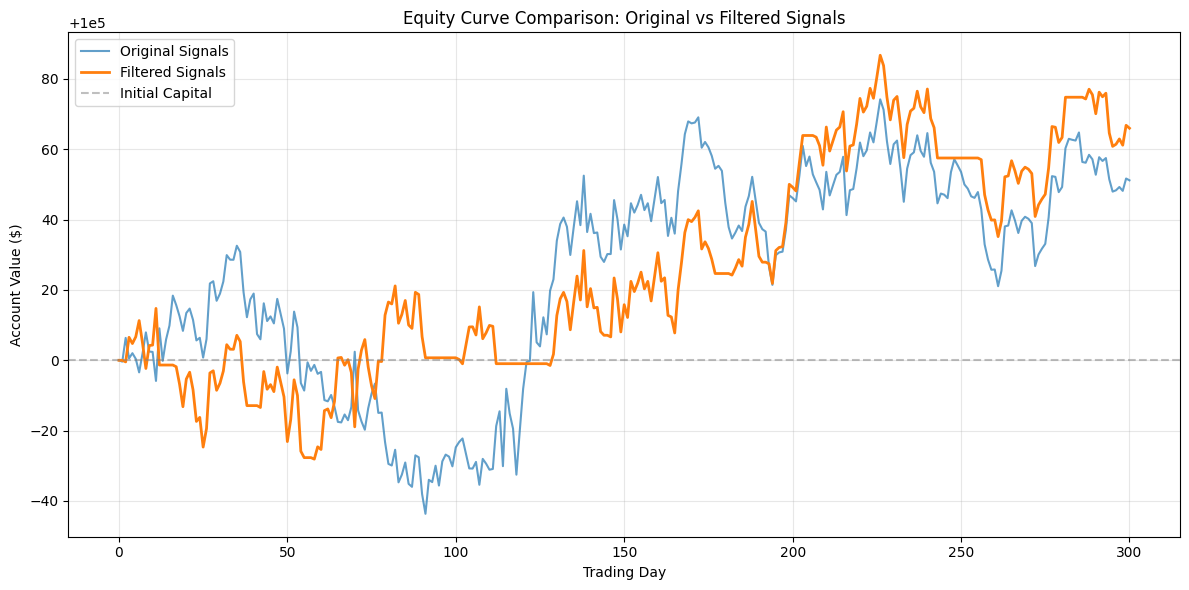


✅ Equity curve chart saved


In [60]:
# Plot equity curves
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(original_results['equity_curve'], label='Original Signals', alpha=0.7)
ax.plot(filtered_results['equity_curve'], label='Filtered Signals', linewidth=2)
ax.axhline(y=100000, color='gray', linestyle='--', alpha=0.5, label='Initial Capital')

ax.set_title('Equity Curve Comparison: Original vs Filtered Signals')
ax.set_xlabel('Trading Day')
ax.set_ylabel('Account Value ($)')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(results_dir / 'equity_comparison.png', dpi=150)
plt.show()

print("\n✅ Equity curve chart saved")

## Summary

This notebook tested the Sharpe ratio optimization modules:

1. **Signal Filter**: Reduced trades by filtering low-confidence signals and unfavorable regimes
2. **Position Sizer**: Applied Kelly criterion and volatility scaling
3. **Risk Management**: Used ATR-based stops, trailing stops, and 1.5:1 risk-reward targets

Check the comparison table above to see if we hit the targets!